In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("./data/CaliforniaHousing/cal_housing.data",header=None)

In [3]:
df.head()

0      1     2       3       4       5       6       7         8
0 -122.23  37.88  41.0   880.0   129.0   322.0   126.0  8.3252  452600.0
1 -122.22  37.86  21.0  7099.0  1106.0  2401.0  1138.0  8.3014  358500.0
2 -122.24  37.85  52.0  1467.0   190.0   496.0   177.0  7.2574  352100.0
3 -122.25  37.85  52.0  1274.0   235.0   558.0   219.0  5.6431  341300.0
4 -122.25  37.85  52.0  1627.0   280.0   565.0   259.0  3.8462  342200.0

In [4]:
X = df.iloc[:, :-1].values # Pick all the rows, all columns but the last one, keep only the underlying array
y = np.log(df.iloc[:,-1].values.reshape(-1,1))

In [5]:
y[0:5]

array([[13.02276401],
       [12.78968394],
       [12.77167051],
       [12.74051713],
       [12.74315064]])

In [6]:
y.shape

(20640, 1)

### Split in train/test and normalize (using `StandardScaler`

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [9]:
scl = StandardScaler()
X_train_scl = scl.fit_transform(X_train)
X_test_scl = scl.transform(X_test)

**Goal:** Can we find hyperparameters of a neural network in a sytematic way? Hyperparameters means
- number of hidden layers
- number of neurons
- learning rates

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [11]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = Sequential() # initialize the nn "factory"
    model.add(Dense(n_neurons, input_shape=X_train.shape[1:])) # Initial input layer
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation='relu'))
    model.add(Dense(1, activation='linear')) # Output layer
    optimizer = SGD(learning_rate)  # Creating stochastic gradient descent with prescribed step-size (learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [12]:
test = build_model(n_hidden=3, learning_rate=1e-2)

In [13]:
test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 3,091
Trainable params: 3,091
Non-trainable params: 0
_________________________________________________________________


In [14]:
test.fit(X_train_scl, y_train)

Train on 15480 samples
15480/15480 [==============================] - 1s 92us/sample - loss: 1.7196


### Use our own black-box optimization solver

In [15]:
def MyWrapper(n_epochs, n_hidden, n_neurons):
    model = build_model(n_hidden, n_neurons)
    model.fit(n_epochs=n_epochs, verbose=0)
    score = model.evaluate(X_test_scl, y_test)
    return score

In [16]:
# optim(MyWrapper, ...)

### Or, we can use a random search from `sklearn`.

In [17]:
# Use a wrapper for our keras model to use in scikit
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [18]:
keras_reg = KerasRegressor(build_model)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
keras_reg.fit(X_train_scl, y_train
              , callbacks=[EarlyStopping(patience=10)]
              , validation_split=0.1
              , epochs=10
              , verbose=0)

   ### Pass our `keras_reg` object to `RandomizedSearchCV` 

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [22]:
# This defines the grid we would sample from
param_distribs = {
    "n_hidden": [1,2,3],  
    "n_neurons": np.arange(1,50), 
    "learning_rate": [3e-4, 3e-3, 3e-2]    
}

In [23]:
random_search = RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=5)

In [24]:
random_search.fit(X_train_scl, y_train, epochs=100
                  , validation_split=0.1, callbacks=[EarlyStopping(patience=10)]
                 )

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 109us/sample - loss: nan - val_loss: nan
Epoch 2/100
 3200/11145 [=======>......................] - ETA: 0s - loss: nan

C:\Users\HP\Anaconda3\envs\huawei\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 59us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
3096/1 [=====================================================================================

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 121us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 57us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 107us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 52us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 118us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 52us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 57us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 65us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 57us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 107us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 51us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 119us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 55us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 2s 159us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 61us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 56us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 52us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 60us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 64us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 60us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 68us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 121us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 49us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 49us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 51us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 52us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 104us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 49us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 51us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 49us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 51us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 118us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 51us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 52us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 54us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 53us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 109us/sample - loss: 31.6037 - val_loss: 1.2135
Epoch 2/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.8085 - val_loss: 0.5154
Epoch 3/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.4182 - val_loss: 0.3085
Epoch 4/100
11145/11145 [==============================] - 1s 59us/sample - loss: 0.2799 - val_loss: 0.2259
Epoch 5/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.2186 - val_loss: 0.1890
Epoch 6/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1852 - val_loss: 0.1687
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1649 - val_loss: 0.1575
Epoch 8/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.1512 - val_loss: 0.1456
Epoch 9/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1

Epoch 76/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0856 - val_loss: 0.0927
Epoch 77/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0857 - val_loss: 0.0921
Epoch 78/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0854 - val_loss: 0.0923
Epoch 79/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0853 - val_loss: 0.0942
Epoch 80/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0850 - val_loss: 0.0917
Epoch 81/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0852 - val_loss: 0.0922
Epoch 82/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0849 - val_loss: 0.0921
Epoch 83/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0849 - val_loss: 0.0929
Epoch 84/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0846 - val_loss: 0.0912
Epoch 85/100
11145/

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 108us/sample - loss: 35.1534 - val_loss: 2.0876
Epoch 2/100
11145/11145 [==============================] - 1s 50us/sample - loss: 1.4466 - val_loss: 0.7441
Epoch 3/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.5908 - val_loss: 0.3358
Epoch 4/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.3070 - val_loss: 0.2226
Epoch 5/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.2280 - val_loss: 0.1881
Epoch 6/100
11145/11145 [==============================] - 1s 55us/sample - loss: 0.1970 - val_loss: 0.1896
Epoch 7/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1793 - val_loss: 0.1654
Epoch 8/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.1675 - val_loss: 0.1575
Epoch 9/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.1

Epoch 76/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0936 - val_loss: 0.0988
Epoch 77/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.0935 - val_loss: 0.0979
Epoch 78/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0934 - val_loss: 0.0978
Epoch 79/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0933 - val_loss: 0.0982
Epoch 80/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0930 - val_loss: 0.0986
Epoch 81/100
11145/11145 [==============================] - ETA: 0s - loss: 0.092 - 1s 50us/sample - loss: 0.0928 - val_loss: 0.0977
Epoch 82/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0927 - val_loss: 0.0982
Epoch 83/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0925 - val_loss: 0.0969
Epoch 84/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.0925 - val_loss: 0.

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 118us/sample - loss: 30.4042 - val_loss: 3.0195
Epoch 2/100
11145/11145 [==============================] - 1s 49us/sample - loss: 2.1372 - val_loss: 1.1697
Epoch 3/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.9417 - val_loss: 0.5929
Epoch 4/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.5240 - val_loss: 0.3675
Epoch 5/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.3558 - val_loss: 0.2721
Epoch 6/100
11145/11145 [==============================] - 1s 54us/sample - loss: 0.2701 - val_loss: 0.2253
Epoch 7/100
11145/11145 [==============================] - 1s 59us/sample - loss: 0.2201 - val_loss: 0.1851
Epoch 8/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.1887 - val_loss: 0.1653
Epoch 9/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1

11145/11145 [==============================] - 1s 50us/sample - loss: 0.0924 - val_loss: 0.1003
Epoch 76/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.0924 - val_loss: 0.0984
Epoch 77/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0923 - val_loss: 0.0984
Epoch 78/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0920 - val_loss: 0.0986
Epoch 79/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.0919 - val_loss: 0.0993
Epoch 80/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0918 - val_loss: 0.0987
Epoch 81/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0917 - val_loss: 0.0985
Epoch 82/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.0915 - val_loss: 0.0982
Epoch 83/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0914 - val_loss: 0.0977
Epoch 84/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 104us/sample - loss: 45.0829 - val_loss: 1.3385
Epoch 2/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.9497 - val_loss: 0.5457
Epoch 3/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.4527 - val_loss: 0.3003
Epoch 4/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.2885 - val_loss: 0.2272
Epoch 5/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.2227 - val_loss: 0.1912
Epoch 6/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.1896 - val_loss: 0.1730
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1709 - val_loss: 0.1612
Epoch 8/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1589 - val_loss: 0.1533
Epoch 9/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1

Epoch 76/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.0902 - val_loss: 0.0943
Epoch 77/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0902 - val_loss: 0.0937
Epoch 78/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.0899 - val_loss: 0.0932
Epoch 79/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0898 - val_loss: 0.0937
Epoch 80/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.0896 - val_loss: 0.0932
Epoch 81/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0894 - val_loss: 0.0926
Epoch 82/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0892 - val_loss: 0.0925
Epoch 83/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0892 - val_loss: 0.0927
Epoch 84/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0889 - val_loss: 0.0928
Epoch 85/100
11145/

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 117us/sample - loss: 36.3225 - val_loss: 3.5229
Epoch 2/100
11145/11145 [==============================] - 1s 50us/sample - loss: 2.0519 - val_loss: 1.3204
Epoch 3/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.7806 - val_loss: 0.5922
Epoch 4/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.3924 - val_loss: 0.3422
Epoch 5/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.2583 - val_loss: 0.2495
Epoch 6/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.2014 - val_loss: 0.2073
Epoch 7/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.1736 - val_loss: 0.1840
Epoch 8/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.1570 - val_loss: 0.1669
Epoch 9/100
11145/11145 [==============================] - 1s 57us/sample - loss: 0.1

Epoch 76/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0911 - val_loss: 0.1019
Epoch 77/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.0910 - val_loss: 0.1008
Epoch 78/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0909 - val_loss: 0.1001
Epoch 79/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0906 - val_loss: 0.1006
Epoch 80/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.0904 - val_loss: 0.1000
Epoch 81/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.0904 - val_loss: 0.1008
Epoch 82/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.0902 - val_loss: 0.1005
Epoch 83/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0899 - val_loss: 0.0999
Epoch 84/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0899 - val_loss: 0.1000
Epoch 85/100
11145/

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 97us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 48us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 49us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 51us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 49us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 49us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [=======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 96us/sample - loss: 5.2246 - val_loss: 0.1652
Epoch 2/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.1322 - val_loss: 0.1354
Epoch 3/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1132 - val_loss: 0.1131
Epoch 4/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1077 - val_loss: 0.1057
Epoch 5/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1077 - val_loss: 0.1208
Epoch 6/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1053 - val_loss: 0.1054
Epoch 7/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1037 - val_loss: 0.1126
Epoch 8/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1056 - val_loss: 0.1050
Epoch 9/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.102

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 112us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 47us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 51us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 49us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 48us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 96us/sample - loss: 5.5128 - val_loss: 0.2566
Epoch 2/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.2472 - val_loss: 0.1737
Epoch 3/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1773 - val_loss: 0.1407
Epoch 4/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1374 - val_loss: 0.1179
Epoch 5/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1227 - val_loss: 0.1176
Epoch 6/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1118 - val_loss: 0.1353
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1101 - val_loss: 0.1049
Epoch 8/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1061 - val_loss: 0.1040
Epoch 9/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.103

Epoch 76/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0767 - val_loss: 0.0891
Epoch 77/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0760 - val_loss: 0.0860
Epoch 78/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0761 - val_loss: 0.0848
Epoch 79/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0759 - val_loss: 0.0875
Epoch 80/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0759 - val_loss: 0.0845
Epoch 81/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0755 - val_loss: 0.0916
Epoch 82/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0755 - val_loss: 0.0833
Epoch 83/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0754 - val_loss: 0.0836
Epoch 84/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0752 - val_loss: 0.0851
Epoch 85/100
11145/

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 97us/sample - loss: nan - val_loss: nan
Epoch 2/100
11145/11145 [==============================] - 1s 48us/sample - loss: nan - val_loss: nan
Epoch 3/100
11145/11145 [==============================] - 1s 49us/sample - loss: nan - val_loss: nan
Epoch 4/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 5/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 6/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: nan - val_loss: nan
Epoch 8/100
11145/11145 [==============================] - 1s 49us/sample - loss: nan - val_loss: nan
Epoch 9/100
11145/11145 [==============================] - 1s 51us/sample - loss: nan - val_loss: nan
Epoch 10/100
11145/11145 [=======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 111us/sample - loss: 25.4549 - val_loss: 2.2005
Epoch 2/100
11145/11145 [==============================] - 1s 47us/sample - loss: 1.4707 - val_loss: 0.8784
Epoch 3/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.7072 - val_loss: 0.4815
Epoch 4/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.4136 - val_loss: 0.3044
Epoch 5/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.2797 - val_loss: 0.2237
Epoch 6/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.2196 - val_loss: 0.1882
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1874 - val_loss: 0.1654
Epoch 8/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1665 - val_loss: 0.1522
Epoch 9/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1

Epoch 76/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0929 - val_loss: 0.1006
Epoch 77/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0928 - val_loss: 0.0996
Epoch 78/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0927 - val_loss: 0.0982
Epoch 79/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0926 - val_loss: 0.0977
Epoch 80/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0926 - val_loss: 0.0976
Epoch 81/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0924 - val_loss: 0.0986
Epoch 82/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.0924 - val_loss: 0.0981
Epoch 83/100
11145/11145 [==============================] - 1s 56us/sample - loss: 0.0922 - val_loss: 0.0975
Epoch 84/100
11145/11145 [==============================] - 1s 60us/sample - loss: 0.0920 - val_loss: 0.0985
Epoch 85/100
11145/

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 95us/sample - loss: 27.8483 - val_loss: 2.7211
Epoch 2/100
11145/11145 [==============================] - 1s 47us/sample - loss: 1.5933 - val_loss: 0.8415
Epoch 3/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.6178 - val_loss: 0.4352
Epoch 4/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.3435 - val_loss: 0.2818
Epoch 5/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.2403 - val_loss: 0.2189
Epoch 6/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1961 - val_loss: 0.1872
Epoch 7/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1734 - val_loss: 0.1661
Epoch 8/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1587 - val_loss: 0.1563
Epoch 9/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.14

Epoch 76/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0967 - val_loss: 0.0978
Epoch 77/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0964 - val_loss: 0.0996
Epoch 78/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0962 - val_loss: 0.0990
Epoch 79/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0962 - val_loss: 0.0981
Epoch 80/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0959 - val_loss: 0.0985
Epoch 81/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0959 - val_loss: 0.0973
Epoch 82/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0959 - val_loss: 0.0979
Epoch 83/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0956 - val_loss: 0.1004
Epoch 84/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.0955 - val_loss: 0.0969
Epoch 85/100
11145/

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 96us/sample - loss: 34.1706 - val_loss: 4.1674
Epoch 2/100
11145/11145 [==============================] - 1s 48us/sample - loss: 2.6285 - val_loss: 1.3265
Epoch 3/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.9187 - val_loss: 0.5675
Epoch 4/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.4761 - val_loss: 0.3558
Epoch 5/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3326 - val_loss: 0.2722
Epoch 6/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.2628 - val_loss: 0.2199
Epoch 7/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.2225 - val_loss: 0.1903
Epoch 8/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1963 - val_loss: 0.1780
Epoch 9/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.17

11145/11145 [==============================] - 1s 49us/sample - loss: 0.0992 - val_loss: 0.1059
Epoch 76/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.0991 - val_loss: 0.1052
Epoch 77/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.0992 - val_loss: 0.1057
Epoch 78/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0989 - val_loss: 0.1053
Epoch 79/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0988 - val_loss: 0.1065
Epoch 80/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0985 - val_loss: 0.1051
Epoch 81/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0986 - val_loss: 0.1067
Epoch 82/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0983 - val_loss: 0.1050
Epoch 83/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0984 - val_loss: 0.1048
Epoch 84/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 97us/sample - loss: 34.6289 - val_loss: 1.5732
Epoch 2/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.9743 - val_loss: 0.5771
Epoch 3/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.4505 - val_loss: 0.3253
Epoch 4/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.2938 - val_loss: 0.2388
Epoch 5/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.2261 - val_loss: 0.1975
Epoch 6/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1915 - val_loss: 0.1739
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1710 - val_loss: 0.1583
Epoch 8/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1576 - val_loss: 0.1490
Epoch 9/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.14

Epoch 76/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0956 - val_loss: 0.0995
Epoch 77/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0954 - val_loss: 0.1001
Epoch 78/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0954 - val_loss: 0.0999
Epoch 79/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0953 - val_loss: 0.0988
Epoch 80/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0951 - val_loss: 0.0990
Epoch 81/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.0950 - val_loss: 0.0995
Epoch 82/100
11145/11145 [==============================] - 1s 56us/sample - loss: 0.0950 - val_loss: 0.0998
Epoch 83/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0948 - val_loss: 0.0989
Epoch 84/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.0947 - val_loss: 0.0986
Epoch 85/100
11145/

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 94us/sample - loss: 39.1334 - val_loss: 2.9155
Epoch 2/100
11145/11145 [==============================] - 1s 47us/sample - loss: 1.4443 - val_loss: 0.7491
Epoch 3/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.5497 - val_loss: 0.4435
Epoch 4/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3616 - val_loss: 0.3309
Epoch 5/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.2835 - val_loss: 0.2784
Epoch 6/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.2411 - val_loss: 0.2446
Epoch 7/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.2148 - val_loss: 0.2218
Epoch 8/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1969 - val_loss: 0.2034
Epoch 9/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.18

Epoch 76/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1001 - val_loss: 0.1088
Epoch 77/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0999 - val_loss: 0.1088
Epoch 78/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0999 - val_loss: 0.1090
Epoch 79/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0997 - val_loss: 0.1079
Epoch 80/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0994 - val_loss: 0.1082
Epoch 81/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0996 - val_loss: 0.1084
Epoch 82/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0994 - val_loss: 0.1076
Epoch 83/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.0992 - val_loss: 0.1079
Epoch 84/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0990 - val_loss: 0.1103
Epoch 85/100
11145/

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 90us/sample - loss: 2.4049 - val_loss: 0.3503
Epoch 2/100
11145/11145 [==============================] - 1s 45us/sample - loss: 0.1287 - val_loss: 0.1295
Epoch 3/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.1219 - val_loss: 0.1252
Epoch 4/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.1079 - val_loss: 0.1101
Epoch 5/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.1118 - val_loss: 0.2205
Epoch 6/100
11145/11145 [==============================] - 1s 45us/sample - loss: 0.1022 - val_loss: 0.1064
Epoch 7/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.1110 - val_loss: 0.3141
Epoch 8/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.0975 - val_loss: 0.1357
Epoch 9/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.093

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 91us/sample - loss: 2.0725 - val_loss: 0.1798
Epoch 2/100
11145/11145 [==============================] - 1s 45us/sample - loss: 0.1461 - val_loss: 0.1945
Epoch 3/100
11145/11145 [==============================] - 1s 45us/sample - loss: 0.1231 - val_loss: 0.6039
Epoch 4/100
11145/11145 [==============================] - 1s 45us/sample - loss: 0.1230 - val_loss: 0.2101
Epoch 5/100
11145/11145 [==============================] - 1s 45us/sample - loss: 0.1119 - val_loss: 0.1187
Epoch 6/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.1070 - val_loss: 0.1576
Epoch 7/100
11145/11145 [==============================] - 1s 45us/sample - loss: 0.1050 - val_loss: 0.1095
Epoch 8/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.1077 - val_loss: 0.1351
Epoch 9/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.102

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 106us/sample - loss: 3.7767 - val_loss: 0.1696
Epoch 2/100
11145/11145 [==============================] - 0s 44us/sample - loss: 0.1428 - val_loss: 0.1137
Epoch 3/100
11145/11145 [==============================] - 0s 45us/sample - loss: 0.1315 - val_loss: 0.1553
Epoch 4/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.1168 - val_loss: 0.1220
Epoch 5/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.1077 - val_loss: 0.1381
Epoch 6/100
11145/11145 [==============================] - 1s 45us/sample - loss: 0.1070 - val_loss: 0.1217
Epoch 7/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.0988 - val_loss: 0.1016
Epoch 8/100
11145/11145 [==============================] - 1s 45us/sample - loss: 0.1018 - val_loss: 0.1123
Epoch 9/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.09

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 108us/sample - loss: 2.0975 - val_loss: 0.1708
Epoch 2/100
11145/11145 [==============================] - 1s 56us/sample - loss: 0.1722 - val_loss: 0.1478
Epoch 3/100
11145/11145 [==============================] - 1s 58us/sample - loss: 0.1192 - val_loss: 0.1373
Epoch 4/100
11145/11145 [==============================] - 1s 57us/sample - loss: 0.1076 - val_loss: 0.1168
Epoch 5/100
11145/11145 [==============================] - 1s 59us/sample - loss: 0.1030 - val_loss: 0.1022
Epoch 6/100
11145/11145 [==============================] - 1s 57us/sample - loss: 0.1043 - val_loss: 0.1132
Epoch 7/100
11145/11145 [==============================] - 1s 55us/sample - loss: 0.1012 - val_loss: 0.0961
Epoch 8/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0974 - val_loss: 0.2150
Epoch 9/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.09

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 89us/sample - loss: 1.9321 - val_loss: 0.1748
Epoch 2/100
11145/11145 [==============================] - 1s 45us/sample - loss: 0.1494 - val_loss: 0.1211
Epoch 3/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.1187 - val_loss: 0.1141
Epoch 4/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.1110 - val_loss: 0.1675
Epoch 5/100
11145/11145 [==============================] - 1s 45us/sample - loss: 0.1018 - val_loss: 0.1012
Epoch 6/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.1004 - val_loss: 0.1235
Epoch 7/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.0997 - val_loss: 0.1113
Epoch 8/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.0975 - val_loss: 0.1053
Epoch 9/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.093

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 101us/sample - loss: 34.8348 - val_loss: 2.5649
Epoch 2/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.8377 - val_loss: 0.3630
Epoch 3/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.3300 - val_loss: 0.3256
Epoch 4/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3224 - val_loss: 0.3245
Epoch 5/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.3222 - val_loss: 0.3246
Epoch 6/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3222 - val_loss: 0.3245
Epoch 7/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.3222 - val_loss: 0.3243
Epoch 8/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.3222 - val_loss: 0.3244
Epoch 9/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.3

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 119us/sample - loss: 34.8565 - val_loss: 2.5473
Epoch 2/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.8427 - val_loss: 0.3603
Epoch 3/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.3344 - val_loss: 0.3256
Epoch 4/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.3269 - val_loss: 0.3245
Epoch 5/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.3267 - val_loss: 0.3243
Epoch 6/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3267 - val_loss: 0.3242
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.3267 - val_loss: 0.3244
Epoch 8/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.3267 - val_loss: 0.3241
Epoch 9/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.3

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 101us/sample - loss: 34.8204 - val_loss: 2.5517
Epoch 2/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.8353 - val_loss: 0.3611
Epoch 3/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.3285 - val_loss: 0.3253
Epoch 4/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3216 - val_loss: 0.3245
Epoch 5/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.3215 - val_loss: 0.3244
Epoch 6/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.3215 - val_loss: 0.3243
Epoch 7/100
11145/11145 [==============================] - 1s 57us/sample - loss: 0.3215 - val_loss: 0.3242
Epoch 8/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3215 - val_loss: 0.3243
Epoch 9/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.3

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 100us/sample - loss: 5.3540 - val_loss: 0.1499
Epoch 2/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1402 - val_loss: 0.1306
Epoch 3/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1297 - val_loss: 0.1220
Epoch 4/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1323 - val_loss: 0.1690
Epoch 5/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1286 - val_loss: 0.1323
Epoch 6/100
11145/11145 [==============================] - ETA: 0s - loss: 0.128 - 1s 48us/sample - loss: 0.1281 - val_loss: 0.1314
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1250 - val_loss: 0.1299
Epoch 8/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1282 - val_loss: 0.1397
Epoch 9/100
11145/11145 [==============================] - 1s 

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 100us/sample - loss: 34.8755 - val_loss: 2.5000
Epoch 2/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.8420 - val_loss: 0.3459
Epoch 3/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3296 - val_loss: 0.3170
Epoch 4/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.3222 - val_loss: 0.3170
Epoch 5/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3221 - val_loss: 0.3170
Epoch 6/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.3221 - val_loss: 0.3170
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.3221 - val_loss: 0.3171
Epoch 8/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3221 - val_loss: 0.3171
Epoch 9/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 99us/sample - loss: 29.2379 - val_loss: 1.1671
Epoch 2/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.6328 - val_loss: 0.3435
Epoch 3/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.3106 - val_loss: 0.3190
Epoch 4/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.2392 - val_loss: 0.2116
Epoch 5/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1995 - val_loss: 0.1851
Epoch 6/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1841 - val_loss: 0.1769
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1703 - val_loss: 0.1694
Epoch 8/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1615 - val_loss: 0.1623
Epoch 9/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.15

Epoch 76/100
11145/11145 [==============================] - 1s 69us/sample - loss: 0.1044 - val_loss: 0.1109
Epoch 77/100
11145/11145 [==============================] - 1s 60us/sample - loss: 0.1042 - val_loss: 0.1110
Epoch 78/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.1040 - val_loss: 0.1111
Epoch 79/100
11145/11145 [==============================] - 1s 58us/sample - loss: 0.1038 - val_loss: 0.1113
Epoch 80/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1036 - val_loss: 0.1105
Epoch 81/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1036 - val_loss: 0.1095
Epoch 82/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1035 - val_loss: 0.1108
Epoch 83/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1035 - val_loss: 0.1100
Epoch 84/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1034 - val_loss: 0.1104
Epoch 85/100
11145/

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 103us/sample - loss: 74.0883 - val_loss: 4.8102
Epoch 2/100
11145/11145 [==============================] - 1s 47us/sample - loss: 2.3288 - val_loss: 0.9024
Epoch 3/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.6840 - val_loss: 0.4663
Epoch 4/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.3973 - val_loss: 0.3254
Epoch 5/100
11145/11145 [==============================] - 1s 56us/sample - loss: 0.2827 - val_loss: 0.2379
Epoch 6/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.2238 - val_loss: 0.1960
Epoch 7/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1901 - val_loss: 0.1710
Epoch 8/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1691 - val_loss: 0.1599
Epoch 9/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1

11145/11145 [==============================] - 1s 49us/sample - loss: 0.1025 - val_loss: 0.1048
Epoch 76/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1024 - val_loss: 0.1056
Epoch 77/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1023 - val_loss: 0.1046
Epoch 78/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1023 - val_loss: 0.1043
Epoch 79/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1020 - val_loss: 0.1041
Epoch 80/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1019 - val_loss: 0.1048
Epoch 81/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1018 - val_loss: 0.1042
Epoch 82/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1018 - val_loss: 0.1037
Epoch 83/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1017 - val_loss: 0.1037
Epoch 84/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 101us/sample - loss: 55.5845 - val_loss: 2.1075
Epoch 2/100
11145/11145 [==============================] - 1s 49us/sample - loss: 1.3971 - val_loss: 0.8729
Epoch 3/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.7173 - val_loss: 0.5326
Epoch 4/100
11145/11145 [==============================] - 1s 56us/sample - loss: 0.5000 - val_loss: 0.3955
Epoch 5/100
11145/11145 [==============================] - 1s 55us/sample - loss: 0.3854 - val_loss: 0.3259
Epoch 6/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.3156 - val_loss: 0.2618
Epoch 7/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.2645 - val_loss: 0.2691
Epoch 8/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.2265 - val_loss: 0.1928
Epoch 9/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1

Epoch 76/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0989 - val_loss: 0.1018
Epoch 77/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0987 - val_loss: 0.1016
Epoch 78/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0987 - val_loss: 0.1011
Epoch 79/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0986 - val_loss: 0.1014
Epoch 80/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0984 - val_loss: 0.1009
Epoch 81/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0983 - val_loss: 0.1008
Epoch 82/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0982 - val_loss: 0.1010
Epoch 83/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0981 - val_loss: 0.1012
Epoch 84/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0980 - val_loss: 0.1021
Epoch 85/100
11145/

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 105us/sample - loss: 48.7305 - val_loss: 2.1785
Epoch 2/100
11145/11145 [==============================] - ETA: 0s - loss: 1.320 - 1s 49us/sample - loss: 1.2996 - val_loss: 0.7578
Epoch 3/100
11145/11145 [==============================] - ETA: 0s - loss: 0.655 - 1s 49us/sample - loss: 0.6492 - val_loss: 0.4962
Epoch 4/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.4590 - val_loss: 0.3717
Epoch 5/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.3579 - val_loss: 0.2947
Epoch 6/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.2955 - val_loss: 0.2496
Epoch 7/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.2533 - val_loss: 0.2145
Epoch 8/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.2230 - val_loss: 0.1921
Epoch 9/100
11145/11145 [============

11145/11145 [==============================] - 1s 49us/sample - loss: 0.0995 - val_loss: 0.1012
Epoch 76/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.0994 - val_loss: 0.1005
Epoch 77/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0993 - val_loss: 0.1003
Epoch 78/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0992 - val_loss: 0.1000
Epoch 79/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0990 - val_loss: 0.0995
Epoch 80/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0990 - val_loss: 0.0990
Epoch 81/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0988 - val_loss: 0.0990
Epoch 82/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.0987 - val_loss: 0.0989
Epoch 83/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.0986 - val_loss: 0.0993
Epoch 84/100
11145/11145 [======

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 104us/sample - loss: 24.8539 - val_loss: 1.4591
Epoch 2/100
11145/11145 [==============================] - 1s 55us/sample - loss: 1.0464 - val_loss: 0.6961
Epoch 3/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.6216 - val_loss: 0.5202
Epoch 4/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.4688 - val_loss: 0.4273
Epoch 5/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.3818 - val_loss: 0.3556
Epoch 6/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.3204 - val_loss: 0.3065
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.2777 - val_loss: 0.2638
Epoch 8/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.2442 - val_loss: 0.2351
Epoch 9/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.2

11145/11145 [==============================] - 2s 189us/sample - loss: 0.0962 - val_loss: 0.0987
Epoch 76/100
11145/11145 [==============================] - 1s 90us/sample - loss: 0.0961 - val_loss: 0.0981
Epoch 77/100
11145/11145 [==============================] - 1s 68us/sample - loss: 0.0960 - val_loss: 0.0985
Epoch 78/100
11145/11145 [==============================] - 1s 66us/sample - loss: 0.0959 - val_loss: 0.0981
Epoch 79/100
11145/11145 [==============================] - 1s 58us/sample - loss: 0.0958 - val_loss: 0.0992
Epoch 80/100
11145/11145 [==============================] - 1s 55us/sample - loss: 0.0958 - val_loss: 0.0984
Epoch 81/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.0957 - val_loss: 0.0985
Epoch 82/100
11145/11145 [==============================] - 1s 58us/sample - loss: 0.0955 - val_loss: 0.0979
Epoch 83/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.0956 - val_loss: 0.0980
Epoch 84/100
11145/11145 [=====

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 94us/sample - loss: 25.9831 - val_loss: 0.1825
Epoch 2/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1388 - val_loss: 0.1344
Epoch 3/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1339 - val_loss: 0.1253
Epoch 4/100
11145/11145 [==============================] - 1s 57us/sample - loss: 0.1231 - val_loss: 0.1219
Epoch 5/100
11145/11145 [==============================] - 1s 61us/sample - loss: 0.1217 - val_loss: 0.1202
Epoch 6/100
11145/11145 [==============================] - 1s 58us/sample - loss: 0.1205 - val_loss: 0.1201
Epoch 7/100
11145/11145 [==============================] - 1s 56us/sample - loss: 0.1182 - val_loss: 0.1229
Epoch 8/100
11145/11145 [==============================] - 1s 61us/sample - loss: 0.1191 - val_loss: 0.1169
Epoch 9/100
11145/11145 [==============================] - 1s 59us/sample - loss: 0.11

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 87us/sample - loss: 15.6319 - val_loss: 0.1532
Epoch 2/100
11145/11145 [==============================] - 0s 45us/sample - loss: 0.1427 - val_loss: 0.1263
Epoch 3/100
11145/11145 [==============================] - 1s 46us/sample - loss: 0.1344 - val_loss: 0.1185
Epoch 4/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.1286 - val_loss: 0.1191
Epoch 5/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.1221 - val_loss: 0.1197
Epoch 6/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.1241 - val_loss: 0.1212
Epoch 7/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.1229 - val_loss: 0.1216
Epoch 8/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1204 - val_loss: 0.1164
Epoch 9/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.12

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 101us/sample - loss: 7.7530 - val_loss: 0.1323
Epoch 2/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1277 - val_loss: 0.1459
Epoch 3/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1259 - val_loss: 0.1208
Epoch 4/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.1225 - val_loss: 0.1215
Epoch 5/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1239 - val_loss: 0.1228
Epoch 6/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.1207 - val_loss: 0.1206
Epoch 7/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1239 - val_loss: 0.1206
Epoch 8/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1232 - val_loss: 0.1187
Epoch 9/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.12

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 120us/sample - loss: 7.5745 - val_loss: 0.1371
Epoch 2/100
11145/11145 [==============================] - 0s 44us/sample - loss: 0.1233 - val_loss: 0.1240
Epoch 3/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.1174 - val_loss: 0.1154
Epoch 4/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1153 - val_loss: 0.1178
Epoch 5/100
11145/11145 [==============================] - 1s 47us/sample - loss: 0.1143 - val_loss: 0.1176
Epoch 6/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1136 - val_loss: 0.1188
Epoch 7/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1127 - val_loss: 0.1208
Epoch 8/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1132 - val_loss: 0.1152
Epoch 9/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.11

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 90us/sample - loss: 12.8935 - val_loss: 0.1770
Epoch 2/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.1332 - val_loss: 0.1288
Epoch 3/100
11145/11145 [==============================] - 1s 48us/sample - loss: 0.1178 - val_loss: 0.1206
Epoch 4/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1161 - val_loss: 0.1223
Epoch 5/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1151 - val_loss: 0.1212
Epoch 6/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.1141 - val_loss: 0.1201
Epoch 7/100
11145/11145 [==============================] - 1s 50us/sample - loss: 0.1149 - val_loss: 0.1256
Epoch 8/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.1147 - val_loss: 0.1184
Epoch 9/100
11145/11145 [==============================] - 1s 49us/sample - loss: 0.11

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 99us/sample - loss: 4.7825 - val_loss: 0.3263
Epoch 2/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.3221 - val_loss: 0.3223
Epoch 3/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.3203 - val_loss: 0.3208
Epoch 4/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.3189 - val_loss: 0.3193
Epoch 5/100
11145/11145 [==============================] - 1s 53us/sample - loss: 0.3161 - val_loss: 0.3151
Epoch 6/100
11145/11145 [==============================] - 1s 54us/sample - loss: 0.3123 - val_loss: 0.3106
Epoch 7/100
11145/11145 [==============================] - 1s 52us/sample - loss: 0.3076 - val_loss: 0.3058
Epoch 8/100
11145/11145 [==============================] - 1s 54us/sample - loss: 0.2996 - val_loss: 0.2946
Epoch 9/100
11145/11145 [==============================] - 1s 51us/sample - loss: 0.284

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 1s 108us/sample - loss: 5.3738 - val_loss: 0.3250
Epoch 2/100
11145/11145 [==============================] - 1s 56us/sample - loss: 0.3275 - val_loss: 0.3240
Epoch 3/100
11145/11145 [==============================] - 1s 57us/sample - loss: 0.3269 - val_loss: 0.3243
Epoch 4/100
11145/11145 [==============================] - 1s 56us/sample - loss: 0.3270 - val_loss: 0.3234
Epoch 5/100
11145/11145 [==============================] - 1s 57us/sample - loss: 0.3269 - val_loss: 0.3235
Epoch 6/100
11145/11145 [==============================] - 1s 60us/sample - loss: 0.3267 - val_loss: 0.3242
Epoch 7/100
11145/11145 [==============================] - 1s 58us/sample - loss: 0.3266 - val_loss: 0.3234
Epoch 8/100
11145/11145 [==============================] - 1s 59us/sample - loss: 0.3265 - val_loss: 0.3232
Epoch 9/100
11145/11145 [==============================] - 1s 59us/sample - loss: 0.32

Train on 11145 samples, validate on 1239 samples
Epoch 1/100
11145/11145 [==============================] - 2s 197us/sample - loss: 4.5119 - val_loss: 0.3246
Epoch 2/100
11145/11145 [==============================] - 1s 84us/sample - loss: 0.3217 - val_loss: 0.3246
Epoch 3/100
11145/11145 [==============================] - 1s 77us/sample - loss: 0.3130 - val_loss: 0.3057
Epoch 4/100
11145/11145 [==============================] - 1s 83us/sample - loss: 0.2789 - val_loss: 0.2452
Epoch 5/100
11145/11145 [==============================] - 1s 79us/sample - loss: 0.2033 - val_loss: 0.1887
Epoch 6/100
11145/11145 [==============================] - 1s 89us/sample - loss: 0.1708 - val_loss: 0.1884
Epoch 7/100
11145/11145 [==============================] - 1s 109us/sample - loss: 0.1398 - val_loss: 0.1393
Epoch 8/100
11145/11145 [==============================] - 1s 72us/sample - loss: 0.1223 - val_loss: 0.1201
Epoch 9/100
11145/11145 [==============================] - 1s 64us/sample - loss: 0.1

KeyboardInterrupt: 

In [ ]:
random_search.best_params_

In [ ]:
random_search.best_score_

In [ ]:
best_model = random_search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test_scl)

In [ ]:
pd.DataFrame(random_search.cv_results_)

### Parity plot

In [30]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(np.exp(y_test), np.exp(y_pred))
plt.xlim(0,5e5)
plt.ylim(0,5e5)

In [26]:
second_best = build_model(n_hidden=1, n_neurons=31)

In [27]:
second_best.fit(X_train_scl, y_train, epochs=100, verbose=0)

In [28]:
y_pred = second_best.predict(X_test_scl)

(9, 15)

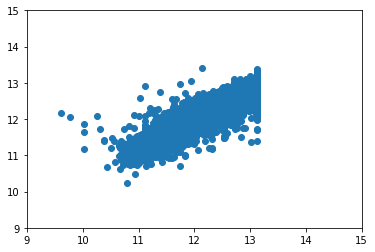

In [31]:
plt.scatter(y_test, y_pred)
plt.xlim(9,15)
plt.ylim(9,15)